# **Multilayer Perceptron From Scratch (Sigmoid activation, MSE Loss)**

## **Libraries**

In [1]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
import torch
import time

/home/amina/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## **Settings**

In [2]:
RANDOM_SEED = 1
BATCH_SIZE = 100
NUM_EPOCHS = 10

## **MNIST dataset**

In [3]:
train_dataset = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor())

In [4]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([100, 1, 28, 28])
Image label dimensions: torch.Size([100])


## **Model Implementation**

In [6]:
class MultilayerPerceptron():
    def __init__(self, num_features, num_hidden, num_classes):
        super(MultilayerPerceptron, self).__init__()
        
        self.num_classes = num_classes
        self.weight_1 = torch.zeros(num_hidden, num_features, dtype=torch.float).normal_(0.0, 0.1)
        self.bias_1 = torch.zeros(num_hidden, dtype=torch.float)
        self.weight_o = torch.zeros(self.num_classes, num_hidden, dtype=torch.float).normal_(0.0, 0.1)
        self.bias_o = torch.zeros(self.num_classes, dtype=torch.float)
        
    def forward(self, x):
        z_1 = torch.mm(x, self.weight_1.t()) + self.bias_1
        a_1 = torch.sigmoid(z_1)
        z_2 = torch.mm(a_1, self.weight_o.t()) + self.bias_o
        a_2 = torch.sigmoid(z_2)
        return a_1, a_2

    def backward(self, x, a_1, a_2, y):  
        y_onehot = torch.FloatTensor(y.size(0), self.num_classes)
        y_onehot.zero_()
        y_onehot.scatter_(1, y.view(-1, 1).long(), 1)
        dloss_da2 = 2.*(a_2 - y_onehot) / y.size(0)
        da2_dz2 = a_2 * (1. - a_2) 
        delta_out = dloss_da2 * da2_dz2 
        dz2__dw_out = a_1
        dloss__dw_out = torch.mm(delta_out.t(), dz2__dw_out)
        dloss__db_out = torch.sum(delta_out, dim=0)
        dz2__a1 = self.weight_o
        dloss_a1 = torch.mm(delta_out, dz2__a1)
        da1__dz1 = a_1 * (1. - a_1) 
        dz1__dw1 = x
        dloss_dw1 = torch.mm((dloss_a1 * da1__dz1).t(), dz1__dw1)
        dloss_db1 = torch.sum((dloss_a1 * da1__dz1), dim=0)

        return dloss__dw_out, dloss__db_out, dloss_dw1, dloss_db1

## **Training phase**

In [7]:
def to_onehot(y, num_classes):
    y_onehot = torch.FloatTensor(y.size(0), num_classes)
    y_onehot.zero_()
    y_onehot.scatter_(1, y.view(-1, 1).long(), 1).float()
    return y_onehot

In [8]:
def loss_func(targets_onehot, probas_onehot):
    return torch.mean(torch.mean((targets_onehot - probas_onehot)**2, dim=0))

In [9]:
def compute_mse(net, data_loader):
    curr_mse, num_examples = torch.zeros(model.num_classes).float(), 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28)
            logits, probas = net.forward(features)
            y_onehot = to_onehot(targets, model.num_classes)
            loss = torch.sum((y_onehot - probas)**2, dim=0)
            num_examples += targets.size(0)
            curr_mse += loss

        curr_mse = torch.mean(curr_mse/num_examples, dim=0)
        return curr_mse

In [10]:
def train(model, data_loader, num_epochs, learning_rate=0.1):
    
    minibatch_cost = []
    epoch_cost = []
    
    for e in range(num_epochs):
        for batch_idx, (features, targets) in enumerate(train_loader):
            features = features.view(-1, 28*28)
            a_1, a_2 = model.forward(features)
            dloss__dw_out, dloss__db_out, dloss_dw1, dloss_db1 = \
                model.backward(features, a_1, a_2, targets)
            model.weight_1 -= learning_rate * dloss_dw1
            model.bias_1 -= learning_rate * dloss_db1
            model.weight_o -= learning_rate * dloss__dw_out
            model.bias_o -= learning_rate * dloss__db_out
            curr_cost = loss_func(to_onehot(targets, model.num_classes), a_2)
            minibatch_cost.append(curr_cost)
            if not batch_idx % 50:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(e+1, NUM_EPOCHS, batch_idx, 
                         len(train_loader), curr_cost))
        
        curr_cost = compute_mse(model, train_loader)
        epoch_cost.append(curr_cost)
        print('Epoch: %03d/%03d |' % (e+1, NUM_EPOCHS), end="")
        print(' Train MSE: %.5f' % curr_cost)

    return minibatch_cost, epoch_cost

In [11]:
torch.manual_seed(RANDOM_SEED)
model = MultilayerPerceptron(num_features=28*28, num_hidden=50, num_classes=10)

In [12]:
minibatch_cost, epoch_cost = train(model, train_loader, num_epochs=NUM_EPOCHS, learning_rate=0.1)

Epoch: 001/010 | Batch 000/600 | Cost: 0.2453
Epoch: 001/010 | Batch 050/600 | Cost: 0.0886
Epoch: 001/010 | Batch 100/600 | Cost: 0.0890
Epoch: 001/010 | Batch 150/600 | Cost: 0.0867
Epoch: 001/010 | Batch 200/600 | Cost: 0.0851
Epoch: 001/010 | Batch 250/600 | Cost: 0.0846
Epoch: 001/010 | Batch 300/600 | Cost: 0.0822
Epoch: 001/010 | Batch 350/600 | Cost: 0.0779
Epoch: 001/010 | Batch 400/600 | Cost: 0.0768
Epoch: 001/010 | Batch 450/600 | Cost: 0.0765
Epoch: 001/010 | Batch 500/600 | Cost: 0.0737
Epoch: 001/010 | Batch 550/600 | Cost: 0.0685
Epoch: 001/010 | Train MSE: 0.06579
Epoch: 002/010 | Batch 000/600 | Cost: 0.0667
Epoch: 002/010 | Batch 050/600 | Cost: 0.0592
Epoch: 002/010 | Batch 100/600 | Cost: 0.0574
Epoch: 002/010 | Batch 150/600 | Cost: 0.0581
Epoch: 002/010 | Batch 200/600 | Cost: 0.0498
Epoch: 002/010 | Batch 250/600 | Cost: 0.0520
Epoch: 002/010 | Batch 300/600 | Cost: 0.0516
Epoch: 002/010 | Batch 350/600 | Cost: 0.0511
Epoch: 002/010 | Batch 400/600 | Cost: 0.048

## **Evaluation**

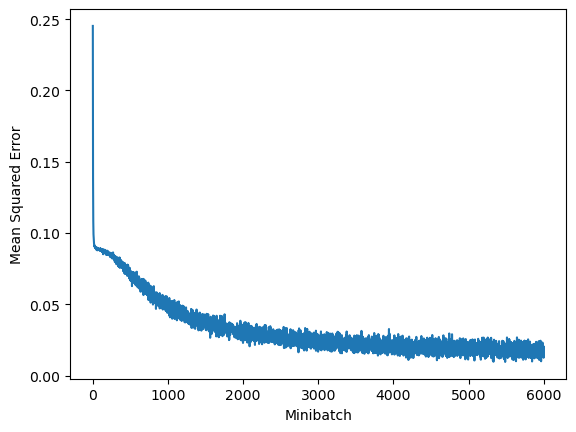

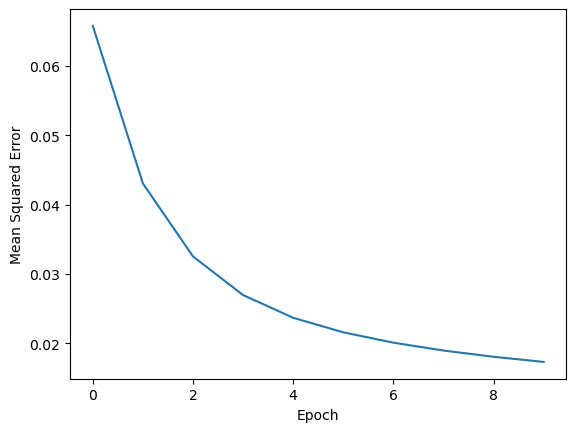

In [13]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

In [14]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28)
            _, outputs = net.forward(features)
            predicted_labels = torch.argmax(outputs, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100
    
print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Training Accuracy: 90.74
Test Accuracy: 91.23


## **Visual Inspection**

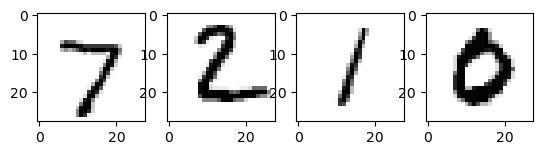

In [15]:
for features, targets in test_loader:
    break
    
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(features[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

In [16]:
_, predictions = model.forward(features[:4].view(-1, 28*28))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions)

Predicted labels tensor([7, 2, 1, 0])
